In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
import utils

In [2]:
nodes_gdf = gpd.read_file('Scigrid_data/IGGIN_Nodes.geojson')
nodes_gdf.head()

,name,id,country_code,tags,param,method,geometry
0,N_0,NO_N_0,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (6.79720 65.10640)
1,N_1,NO_N_1,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (5.19357 59.33286)
2,N_2,NO_N_2,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89575 60.56023)
3,N_3,NO_N_3,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89614 60.78219)
4,N_4,NO_N_4,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (3.29837 54.78877)


In [3]:
pipelines_df = utils.get_IGGIN_pipeline_data()
pipelines_df.head()

,id,name,source_id,lat,long,comment,tags,geometry,diameter_mm,end_year,...,method_long_mean,method_max_cap_M_m3_per_d,method_max_pressure_bar,method_num_compressor,method_start_year,method_waterDepth_m,country_code_1,country_code_2,node_id_1,node_id_2
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"[39.3900748, 38.892435]","[-3.3500984, -1.719831]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_23,INET_N_295
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"[40.01, 40.223]","[-3.207, -3.681]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_1460,INET_N_904
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"[44.991076, 44.90008]","[9.920891, 8.60944]",None,{},None,914.400000,2050,...,make_Attrib(latlong_mean),Lasso,raw,Median,make_Attrib(const),Lasso,IT,IT,INET_N_317,INET_N_26
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"[38.711202, 38.87665]","[-6.382539, -6.9714]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_108
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"[38.711202, 41.506]","[-6.382539, -5.644]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_1653


### Connecting Norwegian grid to the continent

In [4]:
# Dunkerque
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_33', 'node_id_1'] = 'INET_N_407'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_33', 'node_id_2'] = 'INET_N_407'

# Zeebrugge
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_5', 'node_id_1'] = 'INET_N_1656'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_5', 'node_id_2'] = 'INET_N_1656'

# Dornum
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_27', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_27', 'node_id_2'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_1'] == 'Storages_0', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'Storages_0', 'node_id_2'] = 'INET_N_379'

# Emden
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_19', 'node_id_1'] = 'INET_N_436'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_19', 'node_id_2'] = 'INET_N_436'

# Easington
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_39', 'node_id_1'] = 'INET_N_410'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_39', 'node_id_2'] = 'INET_N_410'

# St. Fergus
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_24', 'node_id_1'] = 'INET_N_1401'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_24', 'node_id_2'] = 'INET_N_1401'

# In the nodes_gdf, drop the rows with the following ids
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_33']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_5']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_27']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_19']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_39']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_24']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'Storages_0']

### Add attributes (physical properties) to pipelines

In [5]:
# Create a graph of the pipeline network
G = nx.DiGraph()

# Add the nodes to the graph
for i, row in nodes_gdf.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y), country_code=row['country_code'], is_country_node=False)

# Add the edges to the graph
for i, row in pipelines_df.iterrows():
    if row['node_id_1'] == row['node_id_2']:
        continue
    G.add_edge(row['node_id_1'], row['node_id_2'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_1'],
                                                    country_code_2= row['country_code_2'],
                                                    name= row['name'])
    if row['is_bothDirection']:
        G.add_edge(row['node_id_2'], row['node_id_1'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_2'],
                                                    country_code_2= row['country_code_1'],
                                                    name= row['name'])

### Add country nodes to the grid

In [6]:
G_with_country_nodes = G.copy()

country_positions = {}

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    country_code = node_data.get('country_code')
    if country_code is not None:
        country_code = str.strip(country_code.upper())
    
    if country_code not in country_positions:
        country_positions[country_code] = []
    country_positions[country_code].append(node_data['pos'])

for country_code, positions in country_positions.items():
    average_position = np.mean(positions, axis=0)
    G_with_country_nodes.add_node(country_code, pos=average_position, is_country_node=True, country_code=country_code)

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    if 'country_node' in node_data:
        G_with_country_nodes.remove_node(node_id)

### Direct dead-end flow from nodes to their respective country nodes 

In [7]:
# Get the list of country nodes
country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]

# Iterate over each node in the graph
for node_id, node_data in G_with_country_nodes.nodes(data=True):
    # Skip country nodes
    if node_data.get('is_country_node'):
        continue
    
    # Get the country code of the node
    country_code = node_data.get('country_code')
    
    # Find the corresponding country super node
    country_super_node = next((cn for cn in country_nodes if G_with_country_nodes.nodes[cn]['country_code'] == country_code), None)
    
    if country_super_node:
        # Check if the node is a sink (only incoming edges)
        if G_with_country_nodes.in_degree(node_id) > 0 and G_with_country_nodes.out_degree(node_id) == 0:
            # Calculate the aggregate in-degree capacity of the child node
            aggregate_in_capacity = sum(G_with_country_nodes.edges[neighbor, node_id]['capacity'] for neighbor in G_with_country_nodes.predecessors(node_id))
            
            # Add an edge directed towards the country node from the node with the aggregate in-degree capacity
            G_with_country_nodes.add_edge(node_id, country_super_node, capacity = aggregate_in_capacity)
        
        
        # Check if the node is a source (only outgoing edges)
        if G_with_country_nodes.in_degree(node_id) == 0 and G_with_country_nodes.out_degree(node_id) > 0:
            # Calculate the aggregate out-degree capacity of the child node
            aggregate_out_capacity = sum(G_with_country_nodes.edges[node_id, neighbor]['capacity'] for neighbor in G_with_country_nodes.successors(node_id))
            
            # Add an edge directed towards the node from the country node with the aggregate out-degree capacity
            G_with_country_nodes.add_edge(country_super_node, node_id, capacity = aggregate_out_capacity) 


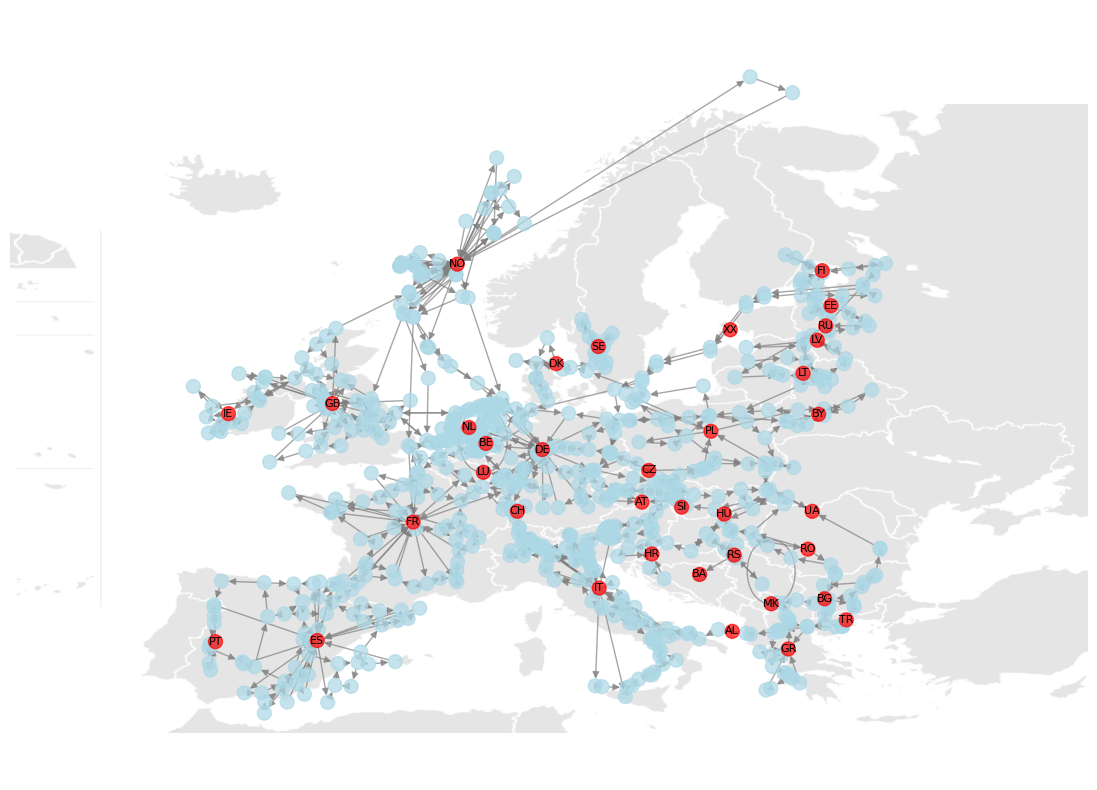

In [8]:
import matplotlib.image as mpimg
europe_map = mpimg.imread('Europe_blank_map.png')

plt.figure(figsize=(15, 10))
plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

pos = nx.get_node_attributes(G_with_country_nodes, 'pos')
node_colors = ['red' if G_with_country_nodes.nodes[node_id].get('is_country_node') else 'lightblue' for node_id in G_with_country_nodes.nodes]
nx.draw(G_with_country_nodes, pos=pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', width=1, alpha=0.7)

country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]
nx.draw_networkx_labels(G_with_country_nodes, pos=pos, labels={node_id: node_id for node_id in country_nodes}, font_color='black', font_size=8)

plt.show()

# Max flow testing

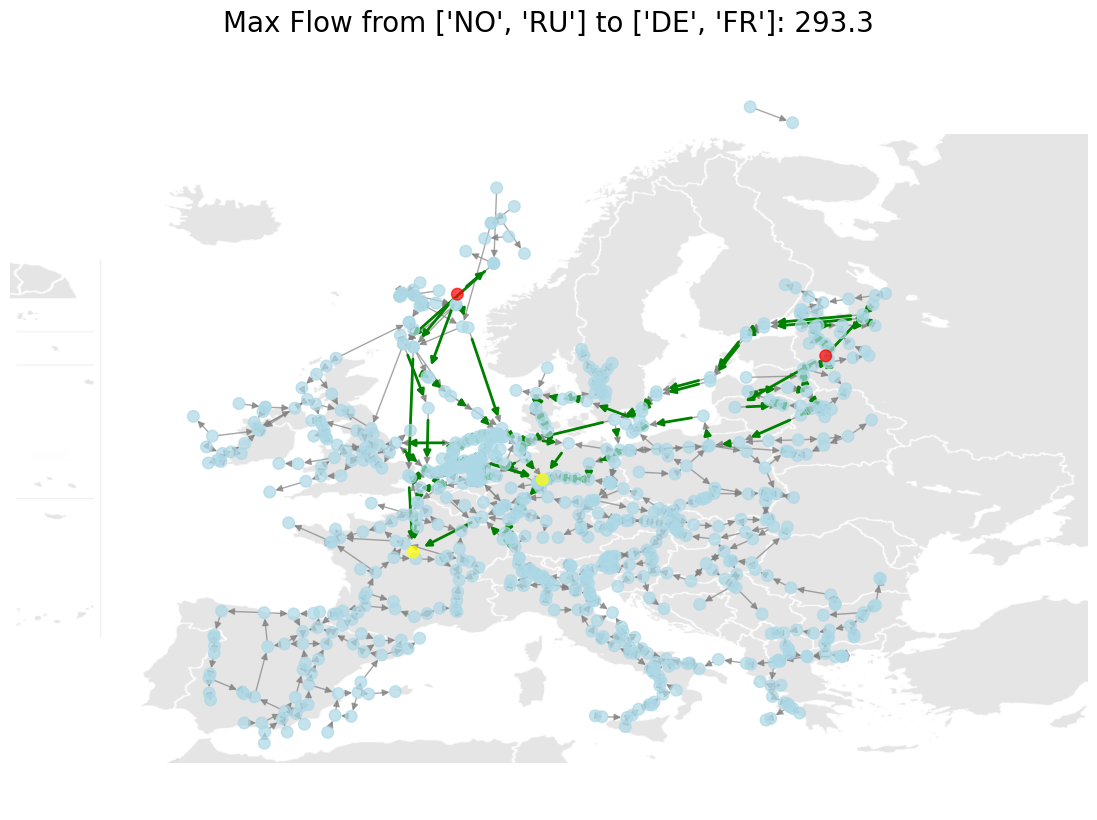

In [9]:
sources = ['NO', 'RU']
sinks = ['DE', 'FR']

flow_val, flow_dict, flow_edges = utils.max_flow(G_with_country_nodes, sources, sinks)

# Cai et al. 2021
### Capacity robustnes based on maximum flow.

In [10]:
import random

def W(flow_dict):
    """ 
    Computes flow matrix W after running max flow algorithm on the graph.
    Defined in Cai et al. (2021) as the flow matrix of the network prior to any node removal.
    
    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    nodes = list(flow_dict.keys())
    num_nodes = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    flow_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                flow_matrix[i, j] = flow_dict.get(nodes[i], {}).get(nodes[j], 0)
    
    return flow_matrix, node_indices


def W_c(flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        modified_flow_matrix: Modified flow matrix
    """

    modified_flow_matrix = np.copy(flow_matrix)

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            modified_flow_matrix[index_v1, index_v2] = 0
            modified_flow_matrix[index_v2, index_v1] = 0
    
    else:
        # Target is a single node
        removed_node_index = node_indices.get(target, None)

        # Exclude the row and column corresponding to the removed node
        modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=0)
        modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=1)

    return modified_flow_matrix

def check_validity(heuristic, remove, k_removals):
        if heuristic not in ['random', 'greedy', 'max_flow']:
            raise ValueError("Invalid heuristic")
        if remove not in ['node', 'edge']:
            raise ValueError("Invalid removal type")
        if not isinstance(k_removals, int) or k_removals < 1:
            raise ValueError("Invalid number of removals")
        if remove=='edge' and G.number_of_edges() < k_removals:
            raise ValueError("Too many edges to remove")
        
        if remove=='node' and G.number_of_nodes() < k_removals:
            raise ValueError("Too many nodes to remove")


In [11]:
from tqdm import tqdm
from tqdm.contrib import tzip


def flow_capacity_robustness(G_, sources, sinks, k_removals, heuristic='random', remove='node', n_benchmarks = 100):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    Defined in Cai et al. (2021) as: sum(W_c_prime) / sum(W_c)
    """

    # Check the validity of the input arguments
    check_validity(heuristic, remove, k_removals)

    G = G_.copy()

    # Remove the country node abstractions from the graph
    country_nodes = [n for n in G.nodes if G.nodes[n].get('is_country_node') and n not in sources and n not in sinks]
    G.remove_nodes_from(country_nodes)

    # Calculate the original flow matrix W of the graph
    flow_val, flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
    flow_matrix, node_indices = W(flow_dict)

    # Instantiate the results dataframe
    results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity', 'entity_data', 'sources', 'sinks', 'network_state', 'flow_dict', 'comment'])
    results_df.loc[0] = [flow_val, 1, None, None, None, sources, sinks, G, flow_dict, 'No removals made']

    # Helper function to check if a node is valid
    def node_is_valid(node):
        return node not in sources and node not in sinks and node != 'super_source' and node != 'super_sink' and node in G.nodes()
    
    # Helper function to check if an edge is valid
    def edge_is_valid(source, sink):
        return source not in sources and sink not in sinks and source != 'super_source' and sink != 'super_sink' and (source, sink) in G.edges() 
    
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':
            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix in zip(G_lst, G_flow_matrix_lst):
                valid_targets = [target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges()) if node_is_valid(target) or edge_is_valid(*target)]
                target = random.choice(valid_targets)
                if remove == 'edge':
                    target_data = G_copy.get_edge_data(*target)
                    G_copy.remove_edge(*target)
                else:
                    target_data = G_copy.nodes[target]
                    G_copy.remove_node(target)

                G_flow_matrix = W_c(G_flow_matrix, target, node_indices)
                W_c_ = G_flow_matrix

                current_max_flow_val, current_flow_dict, _ = utils.max_flow(G_copy, sources, sinks, show_plot=False)
                W_c_prime, _ = W(current_flow_dict)

                capacity_robustness_lst.append(np.sum(W_c_prime) / np.sum(W_c_))
                max_flow_lst.append(current_max_flow_val)

            results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target, target_data, sources, sinks, G_copy.copy(), current_flow_dict,'Specimen graph, averaged across '+str(n_benchmarks)+' benchmarks']

        
        elif heuristic == 'greedy':
            # Project thesis...
            raise NotImplementedError
        

        elif heuristic == 'max_flow':
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)

            # Find the edge that maximizes the flow
            max_flow, target = float('-inf'), None
            max_flow, target = max(((flow, (source, sink)) for source, edges in current_flow_dict.items() for sink, flow in edges.items() if edge_is_valid(source, sink) and flow > max_flow), key=lambda x: x[0], default=(float('-inf'), None))
    
            if remove == 'edge':
                target_data = G.get_edge_data(*target)
                G.remove_edge(*target)
            else:
                target = target[0]
                target_data = G.nodes[target]
                G.remove_node(target)

            # Calculate the flow matrix W_c after removing the node or edge
            flow_matrix = W_c(flow_matrix, target, node_indices)
            W_c_ = flow_matrix

            # Recompute W_c_prime (flow matrix) after the network has sustained damage
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
            W_c_prime, _ = W(current_flow_dict)

            results_df.loc[k] = [current_max_flow_val, np.sum(W_c_prime) / np.sum(W_c_), 'max_flow', target, target_data, sources, sinks, G.copy(), current_flow_dict, None]

            
        # Other heuristics

        else:
            raise ValueError("Invalid heuristic")


    return results_df

c:\Users\Oskar\anaconda3\envs\master_thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
n_benchmarks = 1

## Random heuristic

In [13]:
heuristic = 'random'

### Node removal

In [14]:
remove = 'node'
k_removals = 250

In [15]:
# random_node_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=k_removals, heuristic=heuristic, remove=remove, n_benchmarks=n_benchmarks)
# random_node_removal_df.to_pickle('results/random_node_removal_df.pkl')

random_node_removal_df = pd.read_pickle('results/random_node_removal_df.pkl')
random_node_removal_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,293.301979,1.000000,random,INET_N_80,"{'pos': (23.6, 38.060553999999996), 'country_c...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
2,280.641979,0.893146,random,INET_N_708,"{'pos': (22.72, 55.07), 'country_code': 'LT', ...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
3,280.641979,0.888090,random,INET_N_1309,"{'pos': (12.140796, 43.570594), 'country_code'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
4,280.641979,0.888090,random,INET_N_1574,"{'pos': (13.438998999999999, 45.862614), 'coun...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
...,...,...,...,...,...,...,...,...,...,...
246,55.000000,0.061486,random,INET_N_655,"{'pos': (13.26, 56.97), 'country_code': 'SE', ...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"
247,55.000000,0.061660,random,INET_N_592,"{'pos': (9.9508, 53.5177), 'country_code': 'DE...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"
248,55.000000,0.061486,random,INET_N_1179,"{'pos': (23.848000000000003, 52.144), 'country...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"
249,55.000000,0.061486,random,INET_N_542,"{'pos': (13.54, 57.29), 'country_code': 'SE', ...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"


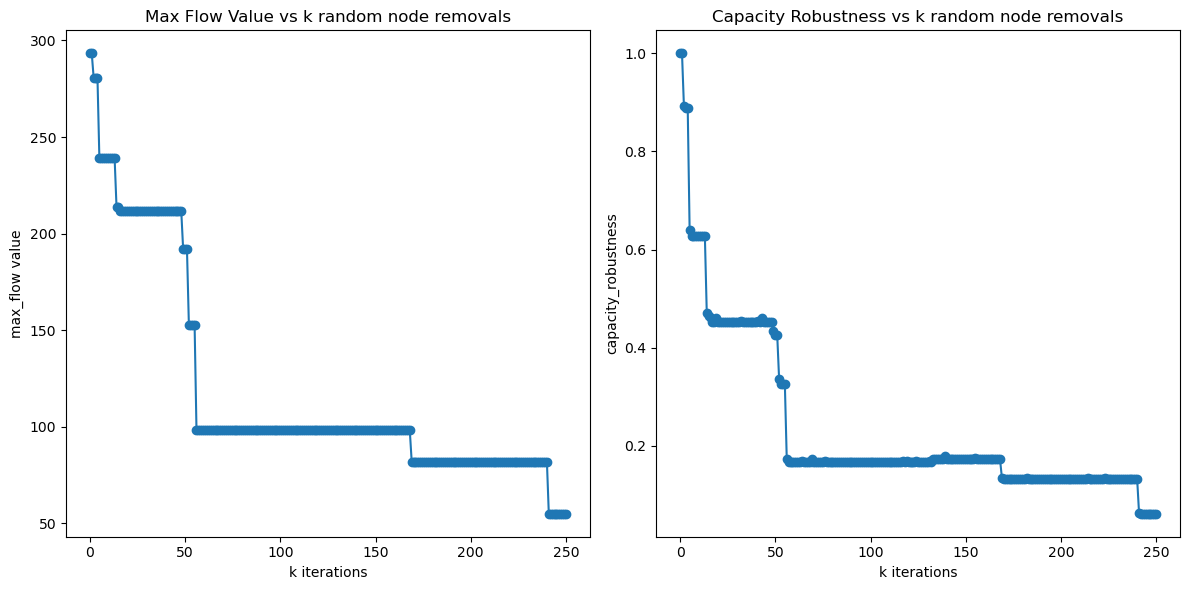

In [16]:
utils.plot_biplot(random_node_removal_df, heuristic, remove)

### Edge removal

In [17]:
remove = 'edge'
k_removals = 250

In [18]:
# random_edge_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=k_removals, heuristic=heuristic, remove=remove, n_benchmarks=n_benchmarks)
# random_node_removal_df.to_pickle('results/random_edge_removal_df.pkl')

random_edge_removal_df = pd.read_pickle('results/random_edge_removal_df.pkl')
random_edge_removal_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,293.301979,1.000000,random,INET_N_80,"{'pos': (23.6, 38.060553999999996), 'country_c...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
2,280.641979,0.893146,random,INET_N_708,"{'pos': (22.72, 55.07), 'country_code': 'LT', ...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
3,280.641979,0.888090,random,INET_N_1309,"{'pos': (12.140796, 43.570594), 'country_code'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
4,280.641979,0.888090,random,INET_N_1574,"{'pos': (13.438998999999999, 45.862614), 'coun...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 1 benchmarks"
...,...,...,...,...,...,...,...,...,...,...
246,55.000000,0.061486,random,INET_N_655,"{'pos': (13.26, 56.97), 'country_code': 'SE', ...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"
247,55.000000,0.061660,random,INET_N_592,"{'pos': (9.9508, 53.5177), 'country_code': 'DE...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"
248,55.000000,0.061486,random,INET_N_1179,"{'pos': (23.848000000000003, 52.144), 'country...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"
249,55.000000,0.061486,random,INET_N_542,"{'pos': (13.54, 57.29), 'country_code': 'SE', ...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_2, NO_N_6, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {}, 'NO_N_6': {}, 'NO...","Specimen graph, averaged across 1 benchmarks"


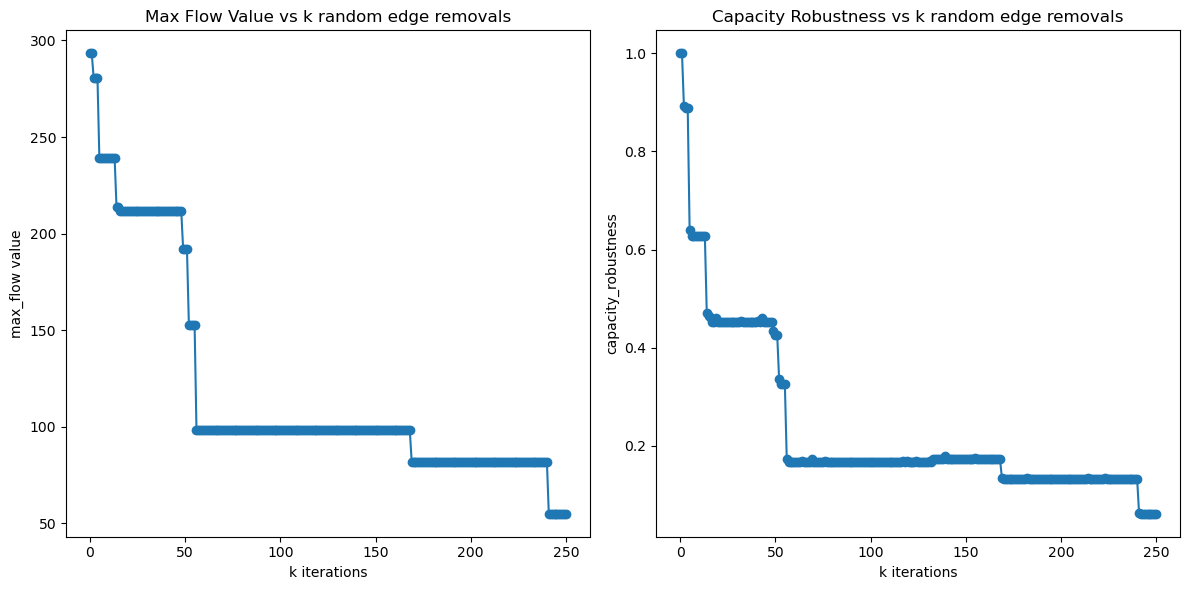

In [19]:
utils.plot_biplot(random_edge_removal_df, heuristic, remove)

## Max flow heuristic

In [20]:
heuristic = 'max_flow'

### Node removal

In [21]:
remove = 'node'
k_removals = 10

In [22]:
# max_flow_node_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=k_removals, heuristic='max_flow', remove='node')
# max_flow_node_removal_df.to_pickle('results/max_flow_node_removal_df.pkl')

max_flow_node_removal_df = pd.read_pickle('results/max_flow_node_removal_df.pkl')
max_flow_node_removal_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_4, NO_N_6, NO_N_7, NO_N_8, NO_N_9, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,213.301979,0.653146,max_flow,INET_N_1172,"{'pos': (28.065696000000003, 60.5549), 'countr...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,154.671842,0.597959,max_flow,INET_N_435,"{'pos': (9.022361, 53.0268), 'country_code': '...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,99.671842,0.545333,max_flow,NO_N_32,"{'pos': (2.46506517720123, 58.188080675194165)...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,56.529786,0.428524,max_flow,INET_N_1656,"{'pos': (3.213, 51.323), 'country_code': 'BE',...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
5,12.660000,0.122255,max_flow,NO_N_12,"{'pos': (3.328996874261654, 56.48970565360146)...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
6,0.000000,0.000000,max_flow,INET_N_1287,"{'pos': (23.0480199, 54.952670999999995), 'cou...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
7,0.000000,0.000000,max_flow,NO_N_0,"{'pos': (6.797201226775478, 65.10639924578797)...","[NO, RU]","[DE, FR]","(NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_6, NO_N_...","{'NO_N_1': {'NO_N_17': 0}, 'NO_N_2': {'NO_N_3'...",None
8,0.000000,0.000000,max_flow,NO_N_1,"{'pos': (5.193570754034167, 59.33285970703154)...","[NO, RU]","[DE, FR]","(NO_N_2, NO_N_3, NO_N_4, NO_N_6, NO_N_7, NO_N_...","{'NO_N_2': {'NO_N_3': 0}, 'NO_N_3': {'NO': 0},...",None
9,0.000000,0.000000,max_flow,NO_N_2,"{'pos': (2.895754899438161, 60.56023487203963)...","[NO, RU]","[DE, FR]","(NO_N_3, NO_N_4, NO_N_6, NO_N_7, NO_N_8, NO_N_...","{'NO_N_3': {'NO': 0}, 'NO_N_4': {}, 'NO_N_6': ...",None


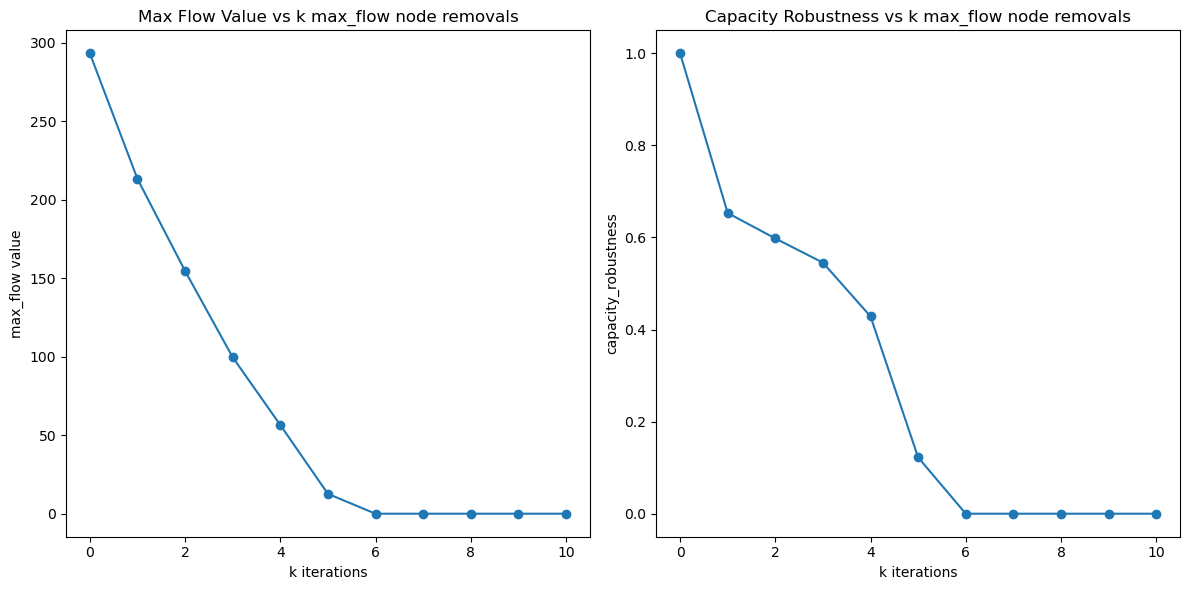

In [23]:
utils.plot_biplot(max_flow_node_removal_df, heuristic, remove)

### Edge removal

In [24]:
remove = 'edge'
k_removals = 10

In [25]:
# max_flow_edge_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=k_removals, heuristic=heuristic, remove=remove)
# max_flow_edge_removal_df.to_pickle('results/max_flow_edge_removal_df.pkl')

max_flow_edge_removal_df = pd.read_pickle('results/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,213.301979,0.641250,max_flow,"(INET_N_1172, INET_N_1052)","{'diameter_mm': 1153.0, 'length_km': 69.157053...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,209.466342,0.691884,max_flow,"(INET_N_435, INET_N_1419)","{'diameter_mm': 1200.0, 'length_km': 141.86369...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,154.466342,0.636509,max_flow,"(NO_N_32, INET_N_407)","{'diameter_mm': 1067.0, 'length_km': 834.23492...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,99.671842,0.513261,max_flow,"(INET_N_435, INET_N_1219)","{'diameter_mm': 1422.0, 'length_km': 58.093189...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
5,58.170317,0.346436,max_flow,"(INET_N_1656, INET_N_912)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
6,12.660000,0.114892,max_flow,"(INET_N_164, INET_N_387)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
7,0.000000,0.000000,max_flow,"(INET_N_1287, INET_N_708)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
8,0.000000,0.000000,max_flow,"(NO_N_0, NO_N_1)","{'diameter_mm': 1067.0, 'length_km': 691.33166...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {'NO_N_17': 0}, 'NO_N...",None
9,0.000000,0.000000,max_flow,"(NO_N_1, NO_N_17)","{'diameter_mm': 711.0, 'length_km': 206.669475...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {}, 'NO_N_2': {'NO_N_...",None


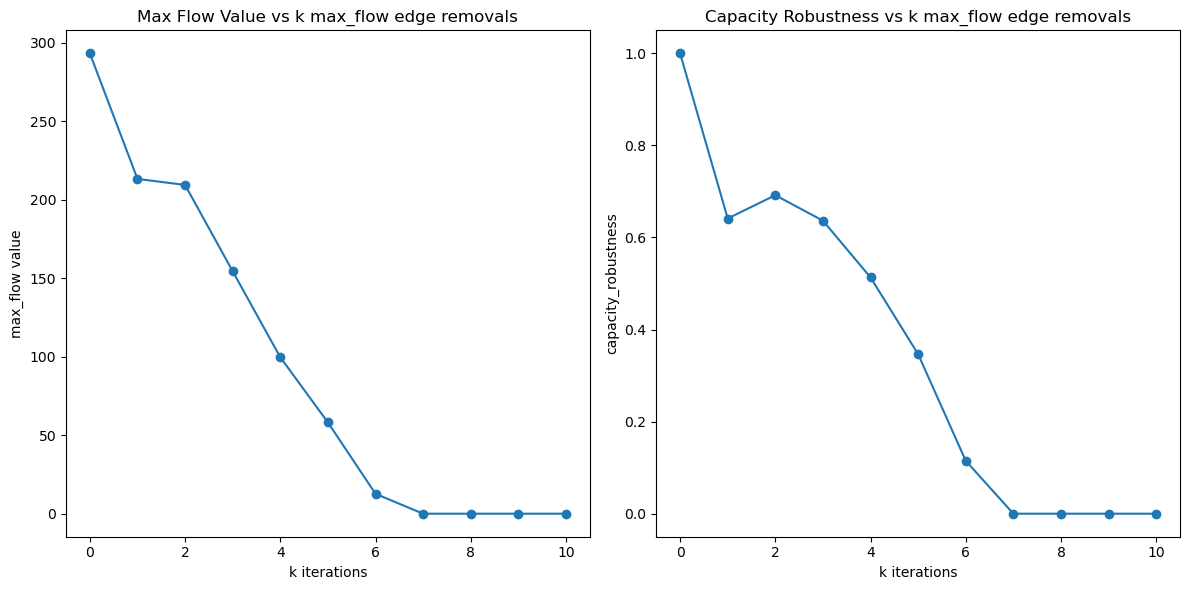

In [26]:
utils.plot_biplot(max_flow_edge_removal_df, heuristic, remove)

# Iterative visualization 

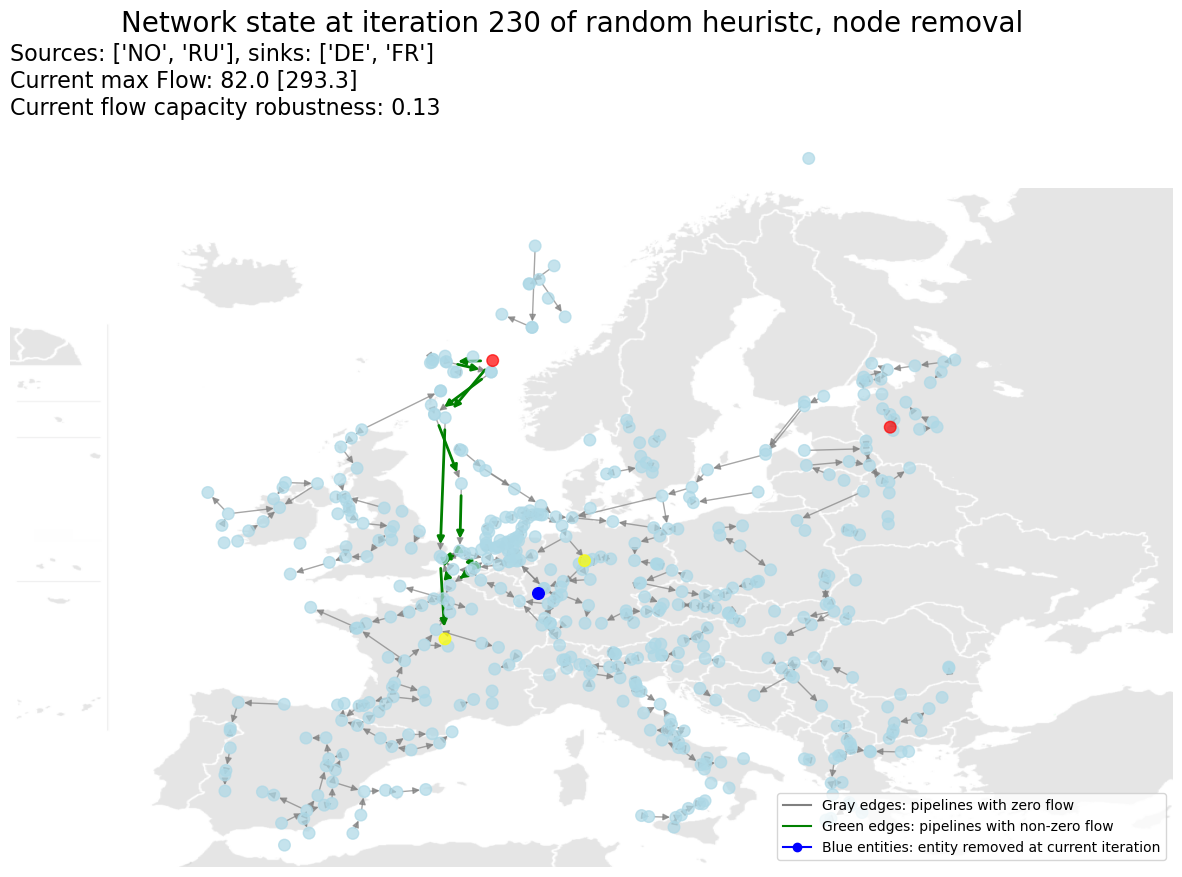

In [27]:
utils.visualize_network_state(random_node_removal_df, iteration=230, only_flow_edges=False)

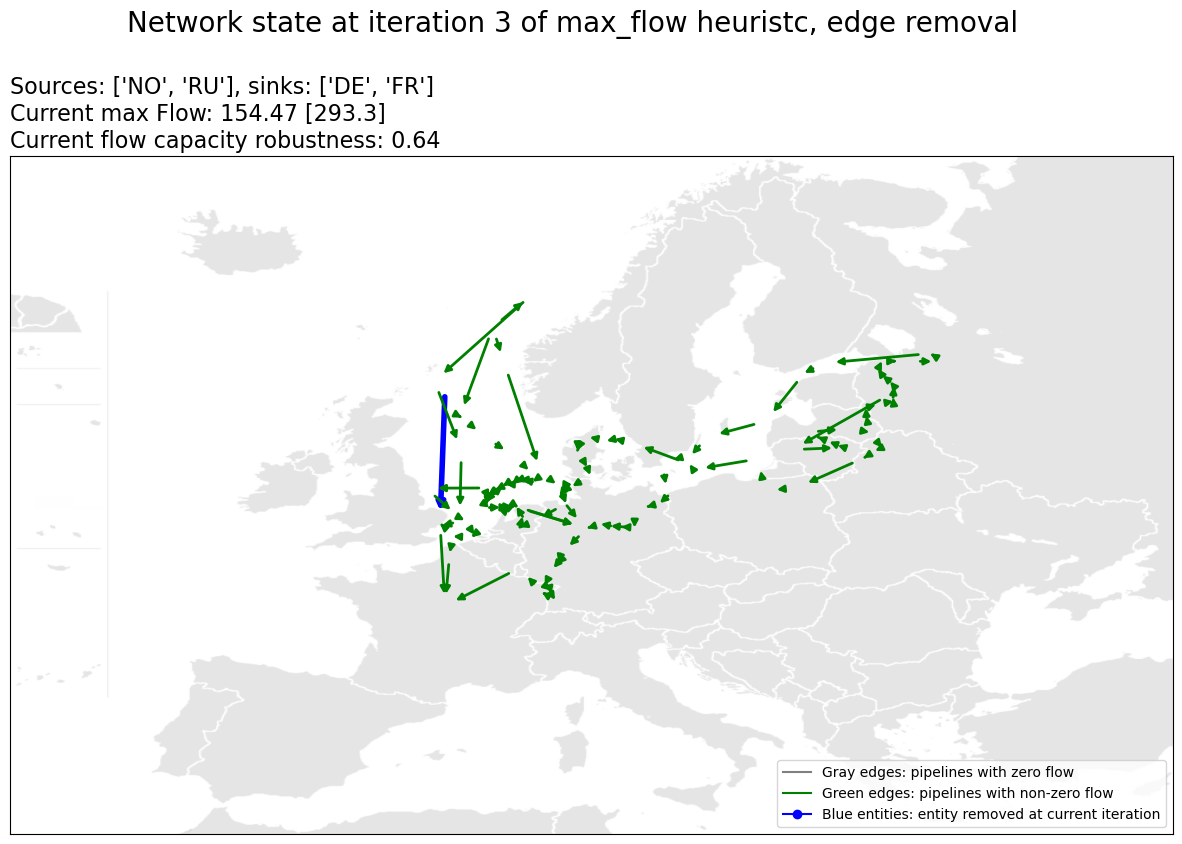

In [28]:
utils.visualize_network_state(max_flow_edge_removal_df, iteration=3, only_flow_edges=True)